# IMPORTAÇÃO DAS BIBLIOTECAS

In [48]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
import datetime
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# IMPORTAÇÃO DOS DATASETS

In [2]:
orders_df=pd.read_csv('dataset/olist_orders_dataset.csv')
customers_df=pd.read_csv('dataset/olist_customers_dataset.csv')
seller_df=pd.read_csv('dataset/olist_sellers_dataset.csv')
items_df=pd.read_csv('dataset/olist_order_items_dataset.csv')
products_df=pd.read_csv('dataset/olist_products_dataset.csv')
product_tr=pd.read_csv('dataset/product_category_name_translation.csv')
order_pay = pd.read_csv("dataset/olist_order_payments_dataset.csv")

# TRADUÇÃO DOS NOMES DOS PRODUTOS PARA O INGLES

In [3]:
category_translations = dict(zip(product_tr['product_category_name'],product_tr['product_category_name_english']))
products_df = products_df.replace({'product_category_name':category_translations})

# MESCLAR TODOS OS DATASETS EM APENAS 1

In [4]:
merge_df=pd.merge(customers_df.drop(['customer_zip_code_prefix'], axis=1), 
                              orders_df.drop(['order_approved_at','order_delivered_carrier_date'],axis=1), how='outer',left_on='customer_id',right_on='customer_id')
merge_df=pd.merge(merge_df, items_df[['order_id','product_id', 'seller_id','price', 'freight_value']], on='order_id')
merge_df=pd.merge(merge_df, seller_df[['seller_id', 'seller_state']], on='seller_id')
merge_df=pd.merge(merge_df, order_pay[['order_id', 'payment_type']], on='order_id')
merge_df=pd.merge(merge_df, products_df[['product_id','product_category_name','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']])
merge_df=merge_df.dropna()

# CONVERTER AS COLUNAS DATA PARA TIMESTAMP

In [6]:
merge_df['order_purchase_time'] = pd.to_datetime(merge_df['order_purchase_timestamp']).dt.time

In [7]:
merge_df['order_purchase_timestamp'] = pd.to_datetime(merge_df['order_purchase_timestamp']).dt.date
merge_df['order_purchase_timestamp2'] = pd.to_datetime(merge_df['order_purchase_timestamp']).dt.date
merge_df['order_delivered_customer_date'] = pd.to_datetime(merge_df['order_delivered_customer_date']).dt.date
merge_df['order_estimated_delivery_date'] = pd.to_datetime(merge_df['order_estimated_delivery_date']).dt.date

In [8]:
merge_df['order_purchase_timestamp'] = pd.to_datetime(merge_df['order_purchase_timestamp'])
merge_df['order_purchase_timestamp2'] = pd.to_datetime(merge_df['order_purchase_timestamp2'])
merge_df['order_purchase_time'] = pd.to_datetime(merge_df['order_purchase_time'],format='%H:%M:%S')
merge_df['order_delivered_customer_date'] = pd.to_datetime(merge_df['order_delivered_customer_date'])
merge_df['order_estimated_delivery_date'] = pd.to_datetime(merge_df['order_estimated_delivery_date'])

In [11]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113405 entries, 0 to 117600
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    113405 non-null  object        
 1   customer_unique_id             113405 non-null  object        
 2   customer_city                  113405 non-null  object        
 3   customer_state                 113405 non-null  object        
 4   order_id                       113405 non-null  object        
 5   order_status                   113405 non-null  object        
 6   order_purchase_timestamp       113405 non-null  datetime64[ns]
 7   order_delivered_customer_date  113405 non-null  datetime64[ns]
 8   order_estimated_delivery_date  113405 non-null  datetime64[ns]
 9   product_id                     113405 non-null  object        
 10  seller_id                      113405 non-null  object        
 11  

# DISTRIBUIÇÃO DO PREÇO

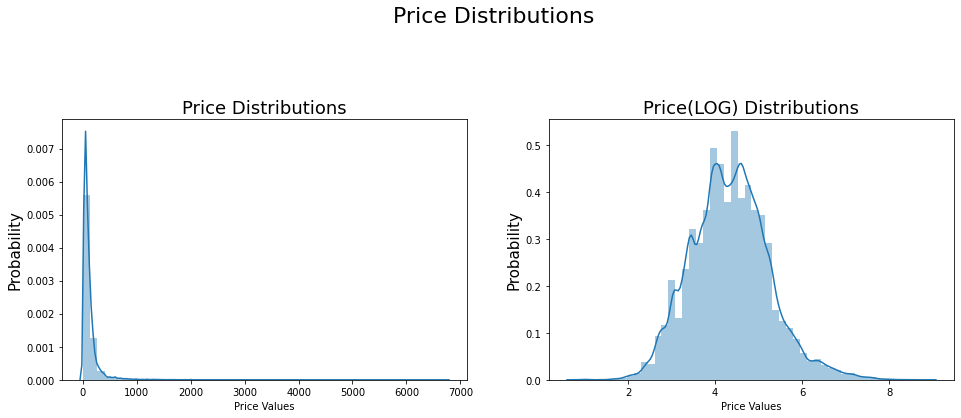

In [85]:
merge_df['price'].fillna(-1, inplace=True)

plt.figure(figsize=(16,12))
plt.suptitle('Price Distributions', fontsize=22)
plt.subplot(221)
g = sns.distplot(merge_df['price'])
g.set_title("Price Distributions", fontsize=18)
g.set_xlabel("Price Values")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(merge_df['price']+1.5))
g1.set_title("Price(LOG) Distributions", fontsize=18)
g1.set_xlabel("Price Values")
g1.set_ylabel("Probability", fontsize=15)

plt.subplots_adjust(hspace = 0.4, top = 0.85)

plt.show()

# TIPOS DE PAGAMENTOS

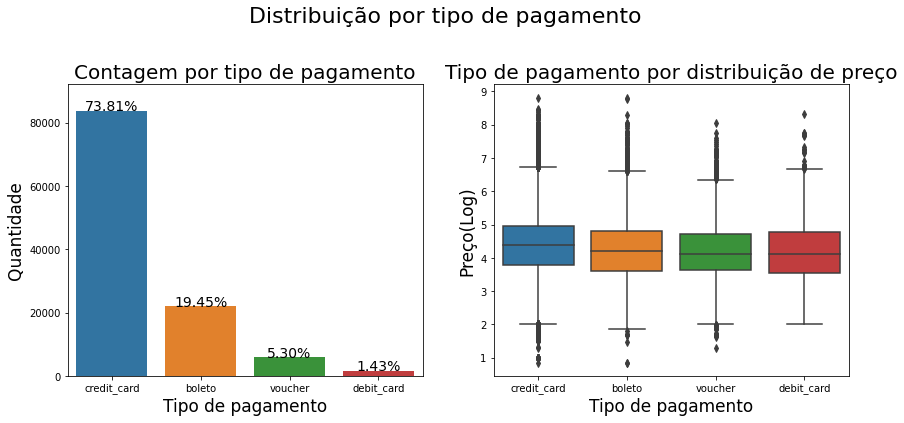

In [12]:
merge_df['price_log'] = np.log(merge_df['price'] + 1.5)

total = len(merge_df)

plt.figure(figsize=(14,6))

plt.suptitle('Distribuição por tipo de pagamento', fontsize=22)

plt.subplot(121)
g = sns.countplot(x='payment_type', data=merge_df[merge_df['payment_type'] != 'not_defined'])
g.set_title("Contagem por tipo de pagamento", fontsize=20)
g.set_xlabel("Tipo de pagamento", fontsize=17)
g.set_ylabel("Quantidade", fontsize=17)

sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.1)

plt.subplot(122)
g = sns.boxplot(x='payment_type', y='price_log', data=merge_df[merge_df['payment_type'] != 'not_defined'])
g.set_title("Tipo de pagamento por distribuição de preço", fontsize=20)
g.set_xlabel("Tipo de pagamento", fontsize=17)
g.set_ylabel("Preço(Log)", fontsize=17)

plt.subplots_adjust(hspace = 0.5, top = 0.8)

plt.show()

# DISTRIBUIÇÃO DE CLIENTES/VENDEDORES POR ESTADO

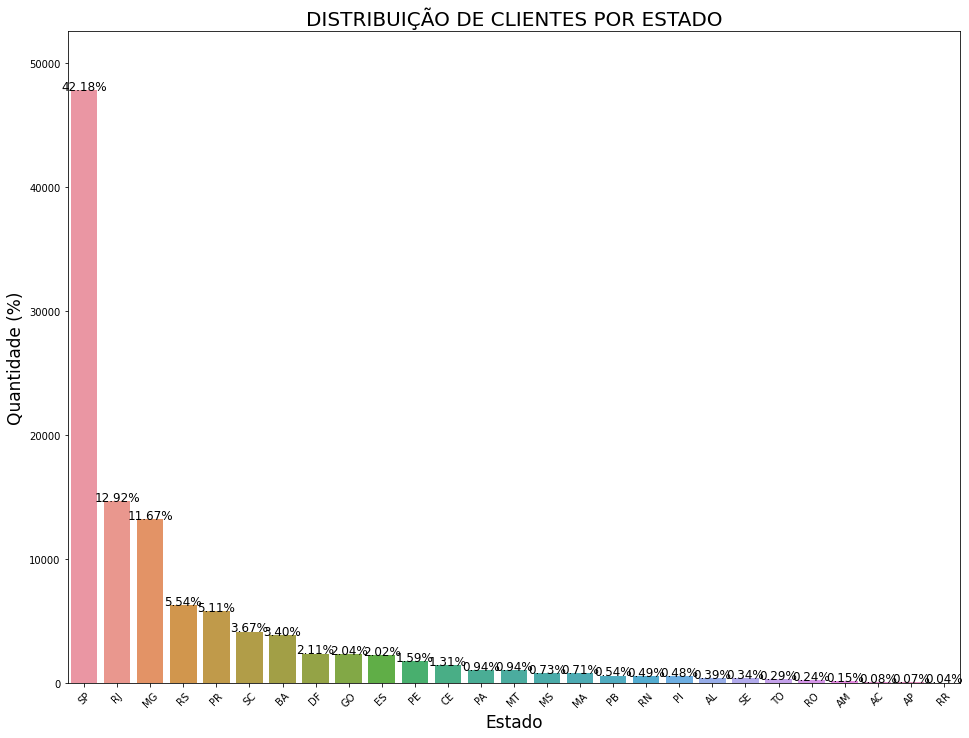

In [14]:
plt.figure(figsize=(16,12))

g = sns.countplot(x='customer_state', data=merge_df, orient='h', order = merge_df['customer_state'].value_counts().index)
g.set_title("DISTRIBUIÇÃO DE CLIENTES POR ESTADO", fontsize=20)
g.set_xlabel("Estado", fontsize=17)
g.set_ylabel("Quantidade (%)", fontsize=17)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.1)

plt.show()

(0.0, 88970.20000000001)

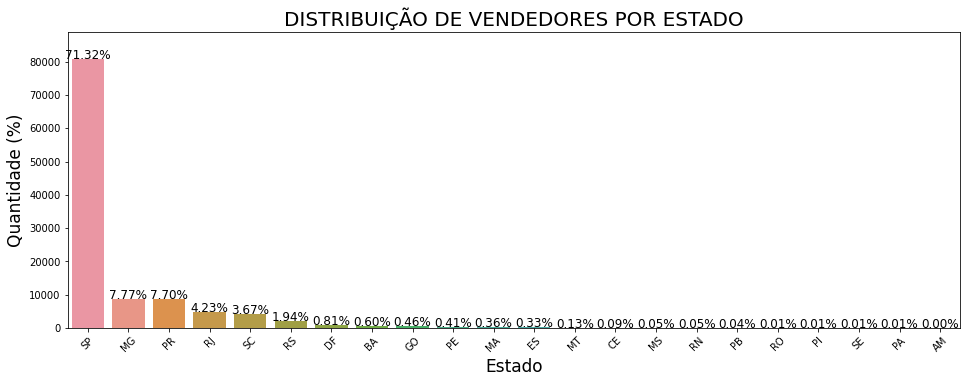

In [65]:
plt.figure(figsize=(16,12))

plt.subplot(212)
g = sns.countplot(x='seller_state', data=merge_df, orient='h', order = merge_df['seller_state'].value_counts().index)
g.set_title("DISTRIBUIÇÃO DE VENDEDORES POR ESTADO", fontsize=20)
g.set_xlabel("Estado", fontsize=17)
g.set_ylabel("Quantidade (%)", fontsize=17)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.1)

# PRODUTOS MAIS VENDIDOS EM CADA MÊS DO ANO

In [66]:
merge_df['purchase_month']=pd.DatetimeIndex(merge_df['order_purchase_timestamp']).month

Text(0, 0.5, 'Total de Vendas')

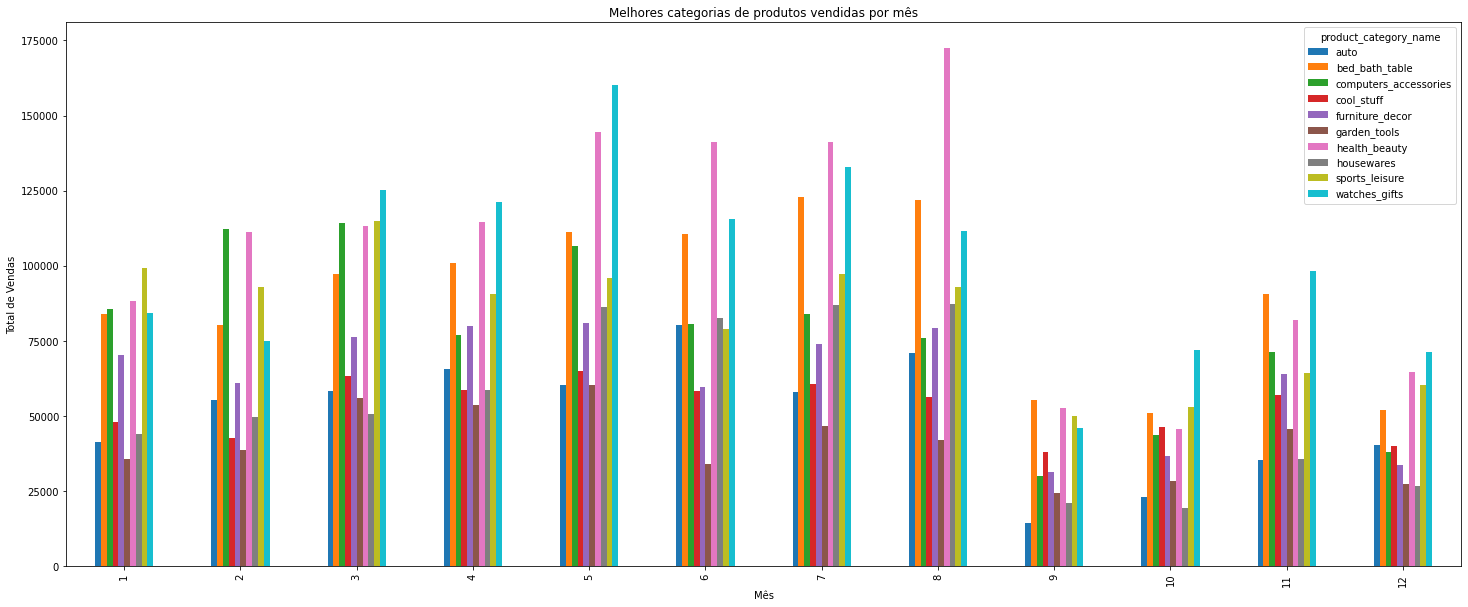

In [84]:
meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro'] 

sales_df=merge_df.groupby(['product_category_name'])['price'].sum()
best_sellers=sales_df.nlargest(10).index

best_df=merge_df[merge_df['product_category_name'].isin(best_sellers)]

best_monthly=best_df.pivot_table(index='purchase_month',columns='product_category_name',values='price', aggfunc='sum')
'''
fig,ax = plt.subplots()
ax.set_xticklabels(meses)
fig.autofmt_xdate(rotation=20)'''

best_monthly.plot(kind='bar',figsize=(25, 10))
plt.title('Melhores categorias de produtos vendidas por mês')
plt.xlabel('Mês')
plt.ylabel('Total de Vendas')
#plt.xticks(meses)

CALCULO DO VALOR DO FRETE POR REGIAO E ESTADO.
CALCULA-SE A MEDIA DO VALOR DE QUAL REGIAO SERÁ ENVIADO O PRODUTO E QUAL O ESTADO DE DESTINO.

In [15]:
sudeste = ['SP', 'RJ', 'ES','MG']
nordeste= ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
norte =  ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
centro_oeste = ['MT', 'GO', 'MS' ,'DF' ]
sul = ['SC', 'RS', 'PR']

merge_df.loc[merge_df['customer_state'].isin(sudeste), 'Regiao do Comprador'] = 'Sudeste'
merge_df.loc[merge_df['customer_state'].isin(nordeste), 'Regiao do Comprador'] = 'Nordeste'
merge_df.loc[merge_df['customer_state'].isin(norte), 'Regiao do Comprador'] = 'Norte'
merge_df.loc[merge_df['customer_state'].isin(centro_oeste), 'Regiao do Comprador'] = 'Centro-Oeste'
merge_df.loc[merge_df['customer_state'].isin(sul), 'Regiao do Comprador'] = 'Sul'

In [16]:
def cross_heatmap(df, cols,normalize=False, values=None, aggfunc=None):
    temp = cols
    cm = sns.light_palette("green", as_cmap=True)
    return pd.crosstab(df[temp[0]], df[temp[1]],  rownames=['Estado do Vendedor'],
                       normalize=normalize, values=values, aggfunc=aggfunc).style.background_gradient(cmap = cm)

In [17]:
cross_heatmap(merge_df[merge_df['price'] != -1], ['seller_state', 'Regiao do Comprador'], 
              values=merge_df[merge_df['price'] != -1]['freight_value'], aggfunc='mean')

Regiao do Comprador,Centro-Oeste,Nordeste,Norte,Sudeste,Sul
Estado do Vendedor,,,,,
AM,nan,28.255000,nan,25.290000,nan
BA,30.273415,22.895625,47.342500,33.642448,40.299467
CE,65.456667,29.290278,85.614000,47.602273,53.125000
DF,12.927647,27.678491,58.371935,19.537642,26.395732
ES,36.895833,37.368039,60.022857,28.796813,40.336800
GO,14.562941,33.571290,26.595909,23.749076,30.641136
MA,27.150192,19.410886,28.859000,31.802922,42.660652
MG,27.095909,34.375710,42.508188,21.153917,29.005198
MS,26.228571,29.412308,21.410000,21.608750,25.600000


ORDEM DE COMPRA DURANTE O DIA

In [18]:
dts = merge_df.copy()

In [19]:
dts['order_purchase_timestamp2'] = dts['order_purchase_timestamp']

In [21]:
dts['day_name'] = dts['order_purchase_timestamp'].dt.day_name()

In [22]:
novo_df = dts[['order_purchase_timestamp', 'order_purchase_timestamp2', 'product_category_name']]

In [23]:
#dts.set_index('order_purchase_timestamp2', inplace=True)

In [ ]:
dts = dts.groupby('order_purchase_timestamp' )['price'].sum()

In [96]:
dts = dts.set_index('order_purchase_timestamp2')

AttributeError: 'Series' object has no attribute 'set_index'

In [1]:
new_df = dts.groupby('order_purchase_timestamp' ).resample('M', on = 'price').sum()
new_df

NameError: name 'dts' is not defined

(array([564, 576]), [Text(0, 0, ''), Text(0, 0, '')])

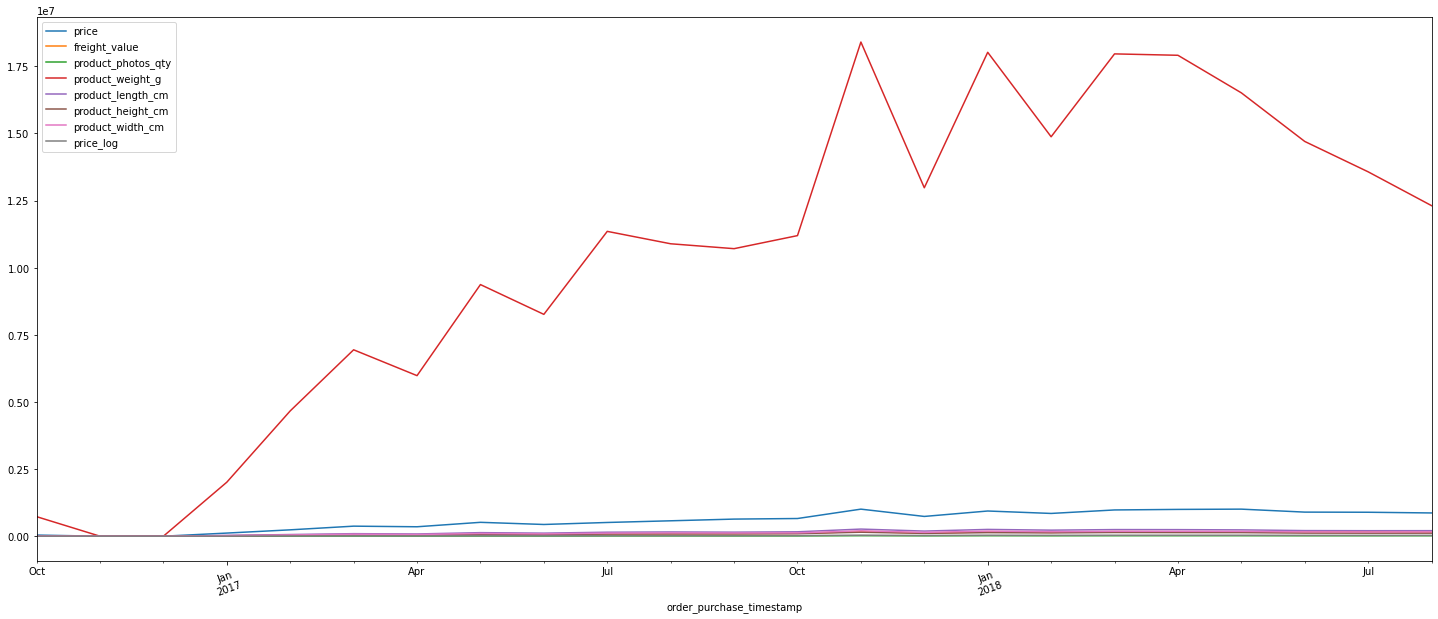

In [88]:
new_df.plot(figsize=(25,10))
plt.xticks(rotation=20)